In [1]:
import numpy as np # indicated numbers and arrays
import tensorflow as tf # build and train AI models
import matplotlib.pyplot as plt # used for drawing chart, images

print("Tensorflow:", tf.__version__)
print("keras (vias tf.keras):", tf.keras.__version__)

Tensorflow: 2.19.0
keras (vias tf.keras): 3.10.0


In [2]:
# Normalization - make data simple for the model by converting data to 0 to 1 instead of 0 to 255
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") / 255).reshape(-1, 784) #(60000, 784)
x_test = (x_test.astype("float32") / 255).reshape(-1, 784) # (10000, 784)
# 0-255 0 - black, 255 - white

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Build Encoder
latent_dim = 2
inputs = tf.keras.Input(shape=(784,), name = "inputs")
h = tf.keras.layers.Dense(256, activation="relu")(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(h) # picks center of the image
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(h) # checks spread or high is the image distributed

In [5]:
class SamplingWithKL(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        # reparameterization : z = mean + std * eps(noise)
        eps = tf.random.normal(shape=tf.shape(z_mean)) # noise
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        # KL divergence per-sample, then average, added as a model loss
        kl_per_sample = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis = 1)
        self.add_loss(tf.reduce_mean(kl_per_sample))
        return z

z = SamplingWithKL(name="z")([z_mean, z_log_var])
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 784)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    200,960 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (SamplingWithKL)  │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Build Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_input")
dh = tf.keras.layers.Dense(256, activation="relu")(latent_inputs)
outputs = tf.keras.layers.Dense(784, activation="sigmoid")(dh)
decoder = tf.keras.Model(latent_inputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_input (InputLayer)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# VAE = Encoder + Decoder
reconstructed = decoder(z)
vae = tf.keras.Model(inputs, reconstructed, name="vae")
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 784)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    200,960 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (SamplingWithKL)  │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 784)       │    202,256 │ z[0][0]           │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
vae.compile(optimizer="adam", loss="binary_crossentropy")

In [12]:
history = vae.fit(x_train, x_train, epochs=20, batch_size=64, validation_data=(x_test, x_test), verbose=1)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.2627 - val_loss: 0.2627
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.2632 - val_loss: 0.2626
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2630 - val_loss: 0.2629
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2627 - val_loss: 0.2626
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2629 - val_loss: 0.2626
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2631 - val_loss: 0.2627
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.2630 - val_loss: 0.2626
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.2628 - val_loss: 0.2626
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.2629 - val_loss: 0.2626
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.2627 - val_loss: 0.2627
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 0.2630 - val_loss: 0.2626
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━

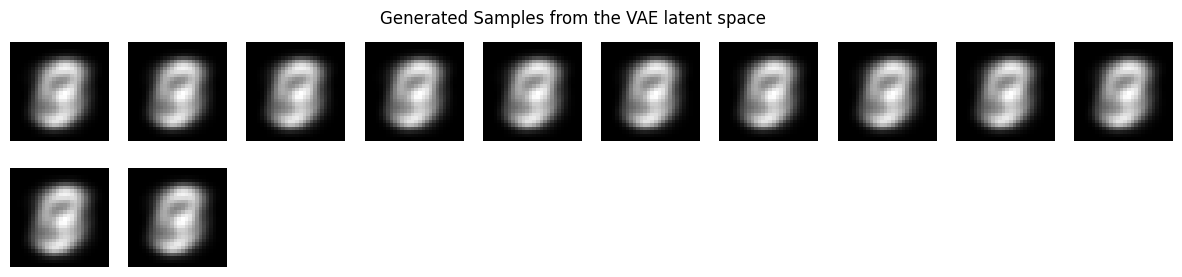

In [13]:
def show_samples(n=12):
  z_random = np.random.normal(size=(n, latent_dim)).astype("float32")
  x_gen = decoder.predict(z_random, verbose=0)
  x_gen = x_gen.reshape(-1, 28, 28)

  cols = min(n, 10)
  rows = int(np.ceil(n / cols))
  plt.figure(figsize=(1.5 * cols, 1.5 * rows))
  for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_gen[i], cmap="gray")
    plt.axis("off")
  plt.suptitle("Generated Samples from the VAE latent space")
  plt.show()

show_samples(12)